# 4.4 Кубический свободный сплайн

Миллер Владимир (696а)

In [27]:
import numpy as np
from matplotlib import pyplot as plt

## Решение системы с 3-х диагональной матрицей.

In [28]:
def solve_tridiagonal_ACB(A, C, B, F):
    """Функция для решения системы Mx=F, где M - 3-х диагональная матрица.

    Args:
        A (numpy.ndarray): поддиагональ матрицы M с фиктивным первым элементом
        C (numpy.ndarray): диагональ матрицы M
        B (numpy.ndarray): наддиагональ матрицы M с фиктивным последним элементом
        F (numpy.ndarray): правая часть системы

    Returns:
        Решение системы.

    """
    
    A = np.array(A, dtype=np.float64)
    C = np.array(C, dtype=np.float64)
    B = np.array(B, dtype=np.float64)
    F = np.array(F, dtype=np.float64)
    n = F.shape[0]
    
    # Преобразование матрицы (системы) в наддиагональный вид.
    C_, F_ = np.copy(C), np.copy(F)
    for i in range(1, n):
        C_[i] -= A[i] * B[i-1] / C_[i-1]
        F_[i] -= A[i] * F_[i-1] / C_[i-1]
        
    # Решение системы прогонкой.
    x = np.zeros(n)
    x[n-1] = F_[n-1] / C_[n-1]
    for i in reversed(range(n-1)):
        x[i] = (F_[i] - B[i] * x[i+1]) / C_[i]
    
    return x

def solve_tridiagonal_M(M, F):
    """Функция для решения системы Mx=F, где M - 3-х диагональная матрица.

    Args:
        M (numpy.ndarray): 3-х диагональная матрица
        F (numpy.ndarray): правая часть системы

    Returns:
        Решение системы.

    """
    
    M = np.array(M, dtype=np.float64)
    F = np.array(F, dtype=np.float64)
    n = F.shape[0]
    
    # Извлечение элементов 3-х диагональной матрицы.
    A, C, B = np.zeros(n), np.zeros(n), np.zeros(n)
    C[0], B[0] = M[0, 0], M[0, 1]
    for i in range(1, n-1):
        A[i], C[i], B[i] = M[i, i-1], M[i, i], M[i, i+1]
    A[n-1], C[n-1] = M[n-1, n-2], M[n-1, n-1]
    
    # Запуск перегруженной функции.
    return solve_tridiagonal_ACB(A, C, B, F)
    

## Реализация класса кубического сплайна

In [36]:
class CubicSpline:
    def __init__(self, x, f, u):
        """Инициализация кубического сплайна.

        Args:
            x (numpy.ndarray): набор узлов 
            f (numpy.ndarray): значения аппроксимируемой функции в узлах 
            u (numpy.ndarray): значения вторых производных сплайна в узлах

        """
        
        self.x = np.array(x, dtype=np.float64)
        self.f = np.array(f, dtype=np.float64)
        self.u = np.array(u, dtype=np.float64)
        self.n = self.x.shape[0]
        self.h = CubicSpline.get_h(self.x)
        self.df = CubicSpline.get_df(self.x, self.f)
            
        # Значения первой производной сплайна в узлах.
        self.dS = np.zeros(self.n, dtype=np.float64)
        for k in range(self.n - 1):
            self.dS[k] = self.df[k+1] \
                         - self.h[k+1] * self.u[k] / 3 \
                         - self.h[k+1] * self.u[k+1] / 6
            
    def __call__(self, x):
        """Вычисление значения сплайна в точке x.

        Args:
            x (float64): точка в области заданных узлов.
        
        """
        
        # Находим отрезок [x_{k-1}, x_{k}], в котором лежит x.
        # Если x находится за границами заданных узлов, то
        #  берём соответствующий крайний отрезок.
        k = self.n - 1
        for i in range(1, self.n):
            if self.x[i] >= x:
                k = i
                break
        
        # Находим t из [0, 1]: x = x_{k-1} + t * (x{k} - x{k-1})
        t = (x - self.x[k-1]) / (self.x[k] - self.x[k-1])
        
        return self.f[k-1] \
               + self.h[k] * t * self.dS[k-1] \
               + self.h[k]**2 * (t/2 + (1-t)**3 / 6 - 1/6) * self.u[k-1] \
               + self.h[k]**2 * t**3 * self.u[k] / 6
    
    @staticmethod
    def get_h(x):
        """ h_{k} = x_{k} - x_{k-1}
        """
        n = x.shape[0]
        h = np.zeros(n, dtype=np.float64)
        for k in range(1, n):
            h[k] = x[k] - x[k-1]
        return h

    @staticmethod
    def get_df(x, f):
        """ df_{k} = (f_{k} - f_{k-1}) / (x_{k} - x_{k-1})
        """
        n = x.shape[0]
        df = np.zeros(n, dtype=np.float64)
        for k in range(1, n):
            df[k] = (f[k] - f[k-1]) / (x[k] - x[k-1])
        return df

## Построение кубического свободного сплайна

In [30]:
def build_spline(x, f):
    """Функция для решения системы Mx=F, где M - 3-х диагональная матрица.

    Args:
        x (numpy.ndarray): набор узлов
        f (numpy.ndarray): значения аппроксимируемой функции в узлах

    Returns:
        Кубический свободный сплайн - объект класса CubicSpline.

    """
    
    x = np.array(x, dtype=np.float64)
    f = np.array(f, dtype=np.float64)
    n = x.shape[0]
    h = CubicSpline.get_h(x)
    df = CubicSpline.get_df(x, f)
    
    # Получение диагоналей 3-х диагональной матрицы системы.
    A = np.zeros(n-2, dtype=np.float64)
    C = np.zeros(n-2, dtype=np.float64)
    B = np.zeros(n-2, dtype=np.float64)
    for i in range(1, n-2):
        A[i] = h[i+1]
    for i in range(n-2):
        C[i] = 2 * (h[i+1] + h[i+2])
    for i in range(n-3):
        B[i] = h[i+2]
        
    # Получение правой части системы.
    P = np.zeros(n-2, dtype=np.float64)
    for i in range(n-2):
        P[i] = 6 * (df[i+2] - df[i+1])
        
    # Решение системы и определение вторых производных сплайна.
    u_mid = solve_tridiagonal_ACB(A, C, B, P)
    u = np.array([0] + list(u_mid) + [0], dtype=np.float64)
    
    # Возвращаем объект кубического свободного сплайна.
    return CubicSpline(x, f, u)

## Функция построения графика

In [42]:
def plot(x, f, spline, figsize):
    """Построение графиков функций f и spline. 
       Точки (x[i], f(x[i])) отмечаются маркерами.

    Args:
        x (numpy.ndarray): набор узлов
        f: функция, определённая lambda-выражением
        spline (CubicSpline): построенный кубический сплайн
        figsize (tuple): размеры графика

    """

    grid = np.linspace(x.min(), x.max(), 512)
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.plot(grid, [spline(p) for p in grid], label="spline")
    ax1.plot(x, f(x), 'o')
    ax1.plot(grid, f(grid), 'k-', label="f")
    ax1.legend()

## Тестирование

### Равномерная сетка

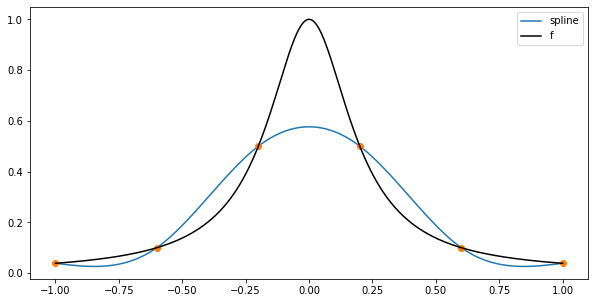

In [47]:
f = lambda x: 1/(25*x**2 + 1)
x = np.linspace(-1, 1, 6)
spline = build_spline(x, f(x))
plot(x, f, spline, (10, 5))

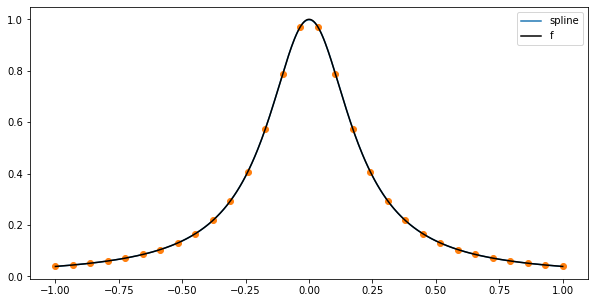

In [50]:
f = lambda x: 1/(25*x**2 + 1)
x = np.linspace(-1, 1, 30)
spline = build_spline(x, f(x))
plot(x, f, spline, (10, 5))

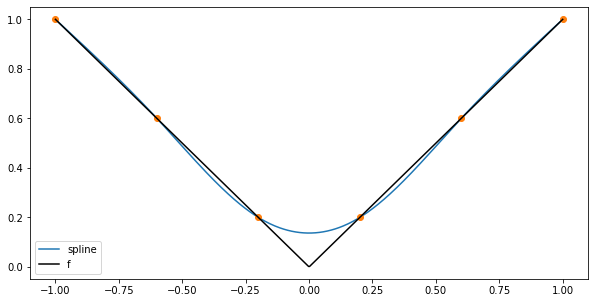

In [51]:
f = lambda x: np.abs(x)
x = np.linspace(-1, 1, 6)
spline = build_spline(x, f(x))
plot(x, f, spline, (10, 5))

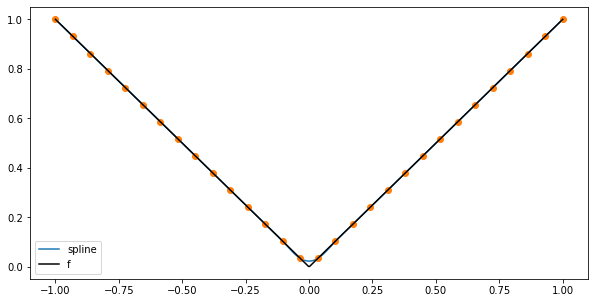

In [52]:
f = lambda x: np.abs(x)
x = np.linspace(-1, 1, 30)
spline = build_spline(x, f(x))
plot(x, f, spline, (10, 5))

### Неравномерная сетка

In [58]:
def irregular_grid(xl, xr, n):
    r = np.random.rand(n-2) * (xr - xl) + xl
    return np.array([xl] + sorted(list(r)) + [xr], dtype=np.float64)

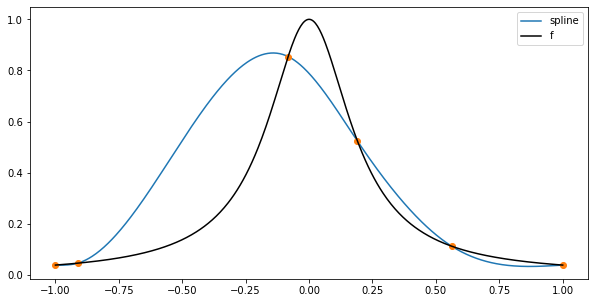

In [60]:
f = lambda x: 1/(25*x**2 + 1)
x = irregular_grid(-1, 1, 6)
spline = build_spline(x, f(x))
plot(x, f, spline, (10, 5))

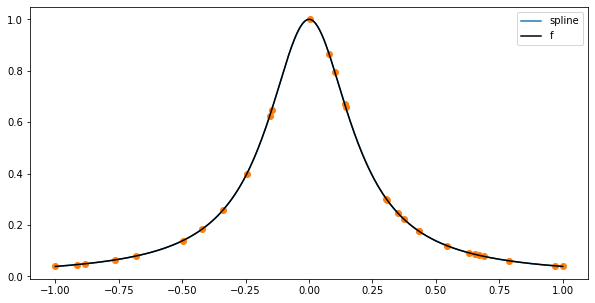

In [61]:
f = lambda x: 1/(25*x**2 + 1)
x = irregular_grid(-1, 1, 30)
spline = build_spline(x, f(x))
plot(x, f, spline, (10, 5))

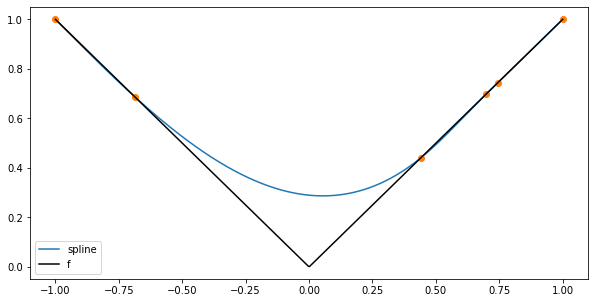

In [62]:
f = lambda x: np.abs(x)
x = irregular_grid(-1, 1, 6)
spline = build_spline(x, f(x))
plot(x, f, spline, (10, 5))

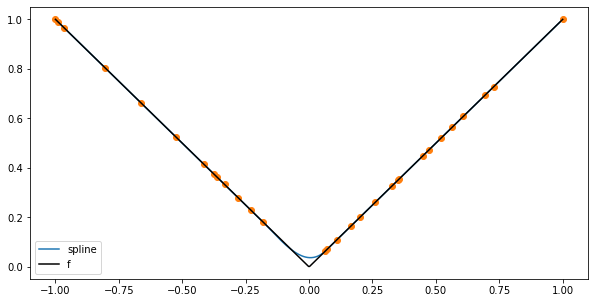

In [63]:
f = lambda x: np.abs(x)
x = irregular_grid(-1, 1, 30)
spline = build_spline(x, f(x))
plot(x, f, spline, (10, 5))